<a href="https://colab.research.google.com/github/carlibeisel/irrigation_efficiency_change/blob/main/pivot_irrigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Identifying Pivot Irrigated Land

By: Carli Beisel

Adapted from David Ketchum (Github: dgketchum)

Created on May 13, 2024

Modified on  May 17, 2024

----------------------------------------------------
**Purpose:**

1) Finds pivot irrigated areas in irrigation shapefile. This code assumes that circles/arcs in the landscape represent pivot irrigation. This script finds arcs in polygon geometries of the shapefile, and writes a new attribute called "pivot". This Script is directly from David Ketchum.

2) Sums area of pivot irrigation for each shapefile and combines into one dataframe. The created dataframe that has two columns: year and total acres of pivot irrigation.

3) Generates a regression plot of irrigation change over time with the genderated dataframe.

## 1. Finds pivot irrigated areas in irrigation shapefile. This code assumes that circles/arcs in the landscape represent pivot irrigation. This script finds arcs in polygon geometries of the shapefile, and writes a new attribute called "pivot".

This script is directly from David Ketchum.


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
! pip install pandarallel
from pandarallel import pandarallel

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16675 sha256=be95d57706899e56c96f99c5d16a11a263e57fa8b222cbedc2e9d62e4a9abd54
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
Mounted at /content/drive


In [ ]:
min_arc = 10
tol = 0.22

In [ ]:
def area_flood_irrigation(shp):
    df = gpd.read_file(shp)
    p = df[df['IType'] == 'P']['geometry']
    p = np.sum([g.area for g in p])
    s = df[df['IType'] == 'S']['geometry']
    s = np.sum([g.area for g in s])
    f = df[df['IType'] == 'F']['geometry']
    f = np.sum([g.area for g in f])
    t = p + s + f
    print('pivot: {:.3f} sqkm, {:.3f}'.format(p / 1e6, p / t))
    print('sprinkler: {:.3f} sqkm, {:.3f}'.format(s / 1e6, s / t))
    print('flood: {:.3f} sqkm, {:.3f}'.format(f / 1e6, f / t))

In [ ]:
# Calculates the bearing between two points given their coordinates.
def bearing(a, b):
    lat1 = np.radians(a[0])
    lat2 = np.radians(b[0])

    diffLong = np.radians(b[1] - a[1])

    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)
                                       * np.cos(lat2) * np.cos(diffLong))

    return np.arctan2(x, y)

In [ ]:
# Identify arcs within a geometry by checking the bearing between consecutive
# vertices. If the bearing difference falls below a certain tolerance for a
# specified number of consecutive vertices (min_arc), it returns True,
# indicating the presence of an arc.

def find_arcs(g):
    verts = g.exterior.coords
    arc_ct, b_prev = 0, np.pi
    for i, v in enumerate(verts):
        try:
            next = verts[i + 1]
        except IndexError:
            break
        b = bearing(v, next)
        diff = b - b_prev
        if diff < tol:
            arc_ct += 1
            if arc_ct >= min_arc:
                return True
        else:
            arc_ct = 0
        b_prev = b

    return False

In [ ]:
# Identify arcs within geometries in a shapefile. It utilizes the find_arcs
# function and parallel processing using the Pandarallel library.

def pivot_test(in_shp, out_shp):
    pandarallel.initialize(use_memory_fs=False, progress_bar=True)

    df = gpd.read_file(in_shp).explode()
    df.index = range(df.shape[0])
    print('{} features'.format(df.shape[0]))
    df['arc'] = df.geometry.apply(lambda g: find_arcs(g))
    df['arc'] = df.geometry.parallel_apply(find_arcs)
    df.to_file(out_shp, crs='epsg:4326')
    print('{} of {} features have an arc'.format(np.count_nonzero(df['arc']), df.shape[0]))

In [ ]:
if __name__ == '__main__':
    in_shp = '/content/drive/MyDrive/Data/irrigation_shapefiles/irrigated_land_only/2022_HDR/2022_irrigated.shp'
    out_shp = '/content/drive/MyDrive/Data/irrigation_shapefiles/pivot/2022_arcs.shp'
    pivot_test(in_shp, out_shp)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


<ipython-input-7-32712a6128df>:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df = gpd.read_file(in_shp).explode()


9382 features


565 of 9382 features have an arc


In [ ]:
# Make sure there is a column named 'Acres' in inputted shapefile.
# If not, use this code to rename the existing column to match

shapefile_path = '/content/drive/MyDrive/Data/irrigation_shapefiles/irrigated_land_only/2022_HDR/2022_irrigated.shp'
gdf = gpd.read_file(shapefile_path)

print("Original columns:", gdf.columns)
gdf = gdf.rename(columns={'Field_Acre': 'Acres'}) #change column name to match your shapefile
print("Renamed columns:", gdf.columns)

output_path = shapefile_path
gdf.to_file(output_path)

Original columns: Index(['Name', 'Watershed', 'Field_Acre', 'MelissaHUC', 'BJ_Com_Tie',
       '_2016_TU_S', 'Classifica', 'SubSegment', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')
Renamed columns: Index(['Name', 'Watershed', 'Acres', 'MelissaHUC', 'BJ_Com_Tie', '_2016_TU_S',
       'Classifica', 'SubSegment', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')


## 2. Sums area of pivot irrigated land and total irrigated land for each shapefile and combines into one dataframe. The created dataframe that has three columns: 1) year, 2) total pivot irrigated acres, and 3) total acres irrigated.

In [1]:
#import libraries
!pip install geopandas shapely
import geopandas as gpd
import glob
import pandas as pd
import re
from shapely.geometry import MultiPolygon #for shapefiles with holes or difficult shapes

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the total irrigated land shapefiles
irrigated_fields = '/content/drive/MyDrive/Data/irrigation_shapefiles/irrigated_land_only/*.shp'
shapefiles = glob.glob(irrigated_fields)

# Define a function to extract the year from the filename
def extract_year(filename):
    match = re.search(r'(\d{4})', filename)
    return int(match.group(1)) if match else None

# Iterate over each shapefile and read the "Acres" column
irrigated_acres = []
for shp in shapefiles:
    year = extract_year(shp)
    if year is None:
        continue

    gdf = gpd.read_file(shp)
    total_area_acres = gdf['Acres'].sum()
    irrigated_acres.append({'Year': year, 'Total Irrigated Acres': total_area_acres})

# Create and sort the DataFrame by Year
all = pd.DataFrame(irrigated_acres).sort_values(by='Year').reset_index(drop=True)

print(all)

   Year  Total Irrigated Acres
0  1987          540858.321895
1  1994          522431.344118
2  2000          543269.737946
3  2004          529101.803133
4  2007          529273.357644
5  2010          527579.091135
6  2015          547752.179370
7  2022          151655.589877


In [ ]:
# Load the pivot irrigation shapefiles
pivot_files = '/content/drive/MyDrive/Data/irrigation_shapefiles/pivot/*.shp'
shapefiles = glob.glob(pivot_files)

# Define a function to extract the year from the filename
def extract_year(filename):
    match = re.search(r'(\d{4})', filename)
    return int(match.group(1)) if match else None

# Iterate over each shapefile and read the "Acres" column where "arc" > 0
pivot_acres = []
for shp in shapefiles:
    year = extract_year(shp)
    if year is None:
        continue

    gdf = gpd.read_file(shp)
    # Filter rows where 'arc' column has values greater than 0
    filtered_gdf = gdf[gdf['arc'] > 0]
    # Sum the 'Acres' column for the filtered rows
    total_area_acres = filtered_gdf['Acres'].sum()
    pivot_acres.append({'Year': year, 'Pivot Acres': total_area_acres})

# Create and sort the DataFrame by Year
pivot = pd.DataFrame(pivot_acres).sort_values(by='Year').reset_index(drop=True)

print(pivot)

   Year    Pivot Acres
0  1987   20963.597703
1  1994   89037.224057
2  2000   53772.965430
3  2004   72878.061439
4  2007   79992.204613
5  2010  117115.605654
6  2015  117012.499447
7  2022   13732.612196


In [ ]:
#merge pivot and all irrigation style dataframes
merged_data = pd.merge(all, pivot, on='Year', how='inner')
print(merged_data)
merged_data.to_csv('/content/drive/MyDrive/Data/irrigation_shapefiles/irrigation_change.csv', index=False)

   Year  Total Irrigated Acres    Pivot Acres
0  1987          540858.321895   20963.597703
1  1994          522431.344118   89037.224057
2  2000          543269.737946   53772.965430
3  2004          529101.803133   72878.061439
4  2007          529273.357644   79992.204613
5  2010          527579.091135  117115.605654
6  2015          547752.179370  117012.499447
7  2022          151655.589877   13732.612196


## 3. Generates a regression plot of irrigation change over time with the genderated dataframe.

In [7]:
# --------------------#
#    Import Libaries  #
# --------------------#

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# ------------------------ #
#    Pivot Proportion      #
# ------------------------ #

# Calculate proportion of pivot irrigated acres divided by total irrigated acres
df = pd.read_csv('/content/drive/MyDrive/Data/irrigation_shapefiles/irrigation_change.csv')

df['Proportion_Pivot'] = df['Pivot Acres'] / df['Total Irrigated Acres'] #old version
print(df)

   Year  Total Irrigated Acres    Pivot Acres  Proportion_Pivot
0  1987          540858.321895   20963.597703          0.038760
1  1994          522431.344118   89037.224057          0.170429
2  2000          543269.737946   53772.965430          0.098980
3  2004          529101.803133   72878.061439          0.137739
4  2007          529273.357644   79992.204613          0.151136
5  2010          527579.091135  117115.605654          0.221987
6  2015          547752.179370  117012.499447          0.213623
7  2022          151655.589877   13732.612196          0.090551


<ipython-input-4-d55cc58505e4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Predicted_Acres'] = model.predict(X)


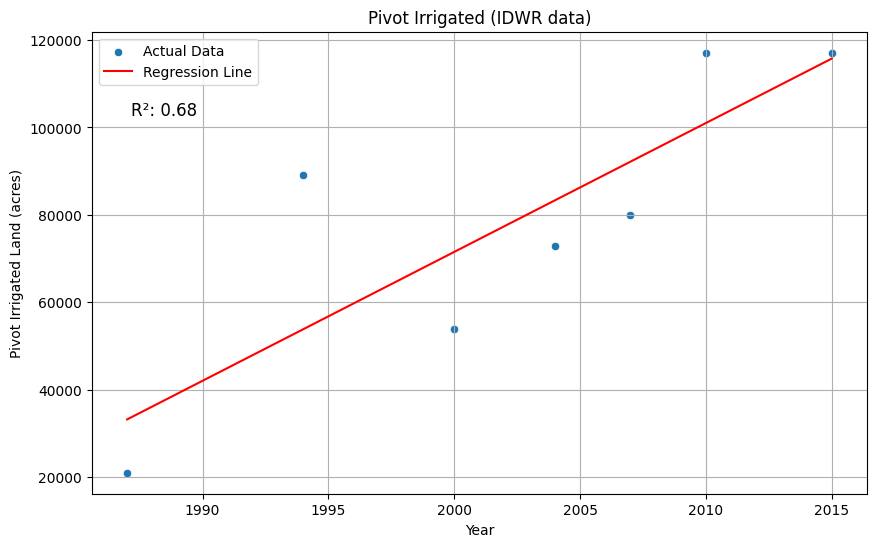

In [4]:
# ----------------------------- #
#    Pivot Irrigated Acres      #
# ----------------------------- #

#exclude 2022 HDR irrigation data

df_filtered = df[df['Year'] != 2022]

# Initialize and fit the linear regression model
model = LinearRegression()
X = df_filtered[['Year']]
y = df_filtered['Pivot Acres']
model.fit(X, y)

# Predict values using the fitted model
df_filtered['Predicted_Acres'] = model.predict(X)

# Calculate the R² value
r_squared = model.score(X, y)

# Plot scatter plot and regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='Year', y='Pivot Acres', marker='o', label='Actual Data')
plt.plot(df_filtered['Year'], df_filtered['Predicted_Acres'], color='red', label='Regression Line')

# Customize the plot
plt.title('Pivot Irrigated (IDWR data)')
plt.xlabel('Year')
plt.ylabel('Pivot Irrigated Land (acres)')
plt.grid(True)
plt.legend()

# Annotate the R² value on the plot
plt.text(
    0.05, 0.85, f'R²: {r_squared:.2f}',
    transform=plt.gca().transAxes, fontsize=12, verticalalignment='top'
)

# Show the plot
plt.savefig('/content/drive/MyDrive/Carli Thesis/Figures/pivot_acres_idwr.tiff', format='tiff', dpi=300)
plt.show()


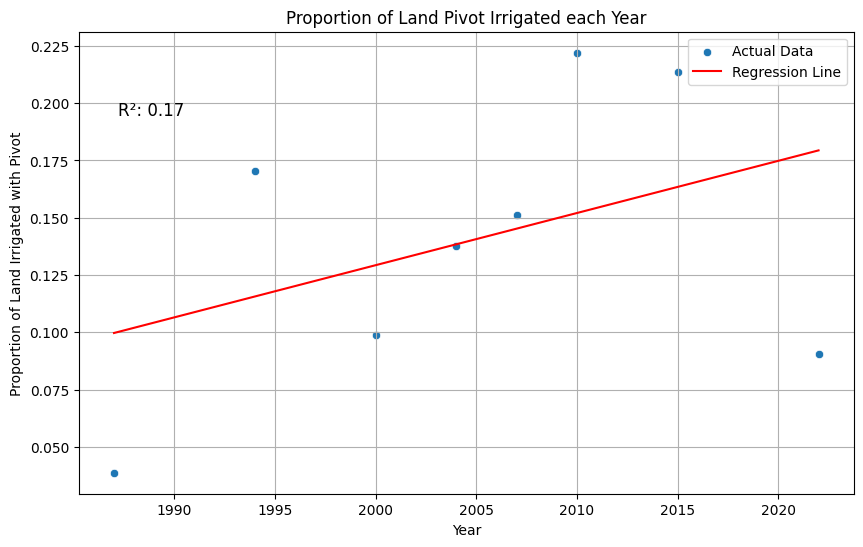

In [ ]:
# -------------------------------- #
#    Create Linear Regression      #
# -------------------------------- #

# Initialize and fit the linear regression model
model = LinearRegression()
X = df[['Year']]
y = df['Proportion_Pivot']
model.fit(X, y)

# Predict values using the fitted model
df['Predicted_Acres'] = model.predict(X)

# Calculate the R² value
r_squared = model.score(X, y)

# Plot scatter plot and regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Year', y='Proportion_Pivot', marker='o', label='Actual Data')
plt.plot(df['Year'], df['Predicted_Acres'], color='red', label='Regression Line')

# Customize the plot
plt.title('Proportion of Land Pivot Irrigated each Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Land Irrigated with Pivot')
plt.grid(True)
plt.legend()

# Annotate the R² value on the plot
plt.text(
    0.05, 0.85, f'R²: {r_squared:.2f}',
    transform=plt.gca().transAxes, fontsize=12, verticalalignment='top'
)

# Show the plot
plt.savefig('/content/drive/MyDrive/Carli Thesis/Figures/pivot_regression.tiff', format='tiff', dpi=300)
plt.show()

<ipython-input-14-b24e1c142843>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Pivot Acres (1000s)'] = df_filtered['Pivot Acres'] / 1000
<ipython-input-14-b24e1c142843>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Total Irrigated Acres (1000s)'] = df_filtered['Total Irrigated Acres'] / 1000
<ipython-input-14-b24e1c142843>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

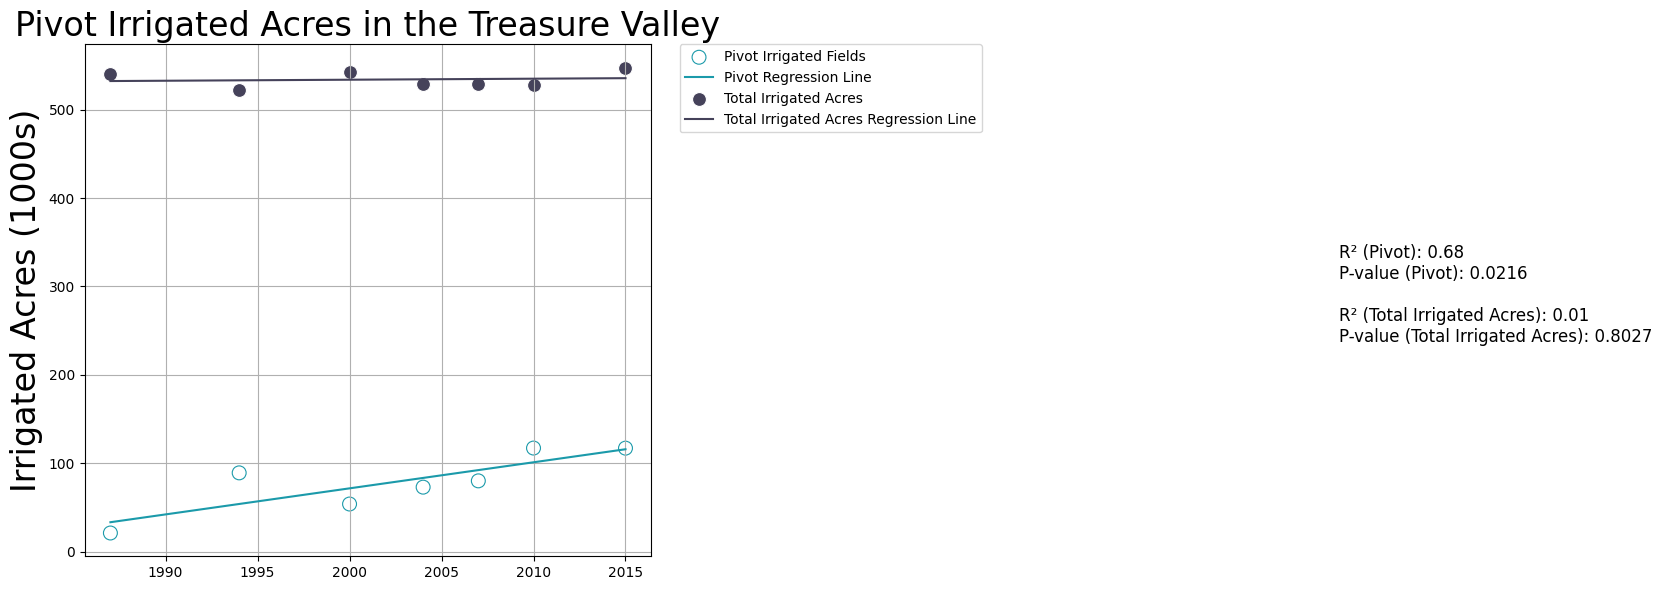

In [14]:
# ----------------------------------- #
#    Pivot & All Irrigated Acres      #
# ----------------------------------- #

# Exclude the year 2022 from the DataFrame
df_filtered = df[df['Year'] != 2022]

# Convert Irrigated Acres values to thousands
df_filtered['Pivot Acres (1000s)'] = df_filtered['Pivot Acres'] / 1000
df_filtered['Total Irrigated Acres (1000s)'] = df_filtered['Total Irrigated Acres'] / 1000

# Initialize and fit the linear regression model for Pivot Acres (in thousands)
model_pivot = LinearRegression()
X_pivot = df_filtered[['Year']]
y_pivot = df_filtered['Pivot Acres (1000s)']
model_pivot.fit(X_pivot, y_pivot)

# Predict values using the fitted model for Pivot Acres (in thousands)
df_filtered['Predicted_Pivot (1000s)'] = model_pivot.predict(X_pivot)

# Calculate p-value for Pivot Acres
slope_pivot, intercept_pivot, r_value_pivot, p_value_pivot, std_err_pivot = linregress(df_filtered['Year'], y_pivot)

# Initialize and fit the linear regression model for Total Irrigated Acres (in thousands)
model_acres = LinearRegression()
y_acres = df_filtered['Total Irrigated Acres (1000s)']
model_acres.fit(X_pivot, y_acres)

# Predict values using the fitted model for Total Irrigated Acres (in thousands)
df_filtered['Predicted_Acres (1000s)'] = model_acres.predict(X_pivot)

# Calculate p-value for Total Irrigated Acres
slope_acres, intercept_acres, r_value_acres, p_value_acres, std_err_acres = linregress(df_filtered['Year'], y_acres)

# Calculate the R² values
r_squared_pivot = model_pivot.score(X_pivot, y_pivot)
r_squared_acres = model_acres.score(X_pivot, y_acres)

# Plot scatter plots and regression lines
plt.figure(figsize=(12, 6))

# Pivot Acres (open circles with larger size and color)
sns.scatterplot(data=df_filtered, x='Year', y='Pivot Acres (1000s)', marker='o', s=100, facecolors='none', edgecolor='#1B9AAA', label='Pivot Irrigated Fields')
plt.plot(df_filtered['Year'], df_filtered['Predicted_Pivot (1000s)'], color='#1B9AAA', label='Pivot Regression Line')

# Total Irrigated Acres
sns.scatterplot(data=df_filtered, x='Year', y='Total Irrigated Acres (1000s)', marker='o', s=100, color='#45425A', label='Total Irrigated Acres')
plt.plot(df_filtered['Year'], df_filtered['Predicted_Acres (1000s)'], color='#45425A', label='Total Irrigated Acres Regression Line')

# Customize the plot
plt.title('Pivot Irrigated Acres in the Treasure Valley', fontsize=24)
plt.xlabel('')
plt.ylabel('Irrigated Acres (1000s)', fontsize=24)
plt.grid(True)

# Display the legend and place it to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Display R² and p-values to the right of the plot
plt.figtext(1.12, 0.5, f'R² (Pivot): {r_squared_pivot:.2f}\nP-value (Pivot): {p_value_pivot:.4f}\n\n'
                        f'R² (Total Irrigated Acres): {r_squared_acres:.2f}\nP-value (Total Irrigated Acres): {p_value_acres:.4f}',
            fontsize=12, verticalalignment='center')

plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.savefig('/content/drive/MyDrive/Carli Thesis/Figures/irrigationchange_TV_regression.svgf', format='svg', dpi=300)
plt.show()